# Machine learning module


In [ ]:
!pip install optuna
!pip install xgboost
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier, callback
from sklearn.svm import LinearSVC
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice, plot_contour, plot_intermediate_values

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 11.4 MB/s eta 0:00:00


In [ ]:
# Carregar dataset de todos os videos
def load_dataset(csv_path, feature, janela, stride):
  X, Y = [], []
  for label in ("correct", "incorrect"):
    results_path = os.path.join(csv_path, label) #"/content/drive/MyDrive/results_csv/correct ou incorrect"
    for results_name in os.listdir(results_path): #correct_01.csv etc...
      df = pd.read_csv(os.path.join(results_path, results_name))
      times_series = time_series_window_embedding(df[feature].values, window=janela, stride=stride)
      for t in times_series: #Para cada times_series, armazena o vetor e o rótulo
        X.append(t)       #t é array shape=(janela,)
        Y.append(0 if label=="incorrect" else 1) #rotula 1 correto 0 incorreto

  X = np.vstack(X)          #shape = (n_frames_total, janela)
  y = np.array(Y)           #shape = (n_frames_total,)
  print(f"X.shape = {X.shape}, y.shape = {y.shape}")
  return X, y

In [ ]:
#Estudo com optuna
def optuna_study(X, y, clf_name, n_trials):
  X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y) #divisao para o conjunto de teste nao entrar no estudo
  def objective(trial):
    X_tr, X_val, y_tr, y_val = train_test_split(X_trainval, y_trainval,test_size=0.20, random_state=42,stratify=y_trainval)
    if clf_name == "dtc":
      #paramentros do DTC
      params = {
        "criterion":         trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth":         trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 1, 20),
        "max_leaf_nodes":    trial.suggest_int("max_leaf_nodes", 2, 100),
        "max_features":      trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "class_weight":      trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state":      42}
      clf = DecisionTreeClassifier(**params)
    elif clf_name == "xgb":
      #parametros XGBoost
      params = {
        "n_estimators":      trial.suggest_int("n_estimators", 50, 500),
        "max_depth":         trial.suggest_int("max_depth", 3, 12),
        "learning_rate":     trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "subsample":         trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":             trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha":         trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":        trial.suggest_float("reg_lambda", 0.0, 5.0),
        "use_label_encoder": False,
        "eval_metric":       "logloss",
        "random_state":      42}
      clf = XGBClassifier(**params)
    elif clf_name == "svc":
      # normalização (sempre que usar SVM)
      scaler = StandardScaler().fit(X_tr)
      X_tr = scaler.transform(X_tr)
      X_val = scaler.transform(X_val)
      params = {
        "C":        trial.suggest_loguniform("C", 1e-3, 1e2),
        "tol":      trial.suggest_loguniform("tol", 1e-5, 1e-2),
        "max_iter": trial.suggest_int("max_iter", 500, 5000),
        "dual":     False,
        "random_state": 42}
      clf = LinearSVC(**params)
    else:
      raise ValueError(f"Model {clf_name!r} não suportado")

    #treina e avalia
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_val)
    return accuracy_score(y_val, preds)

  storage_path = "sqlite:////content/drive/MyDrive/optuna_estudos.db"
  study = optuna.create_study(study_name=f"estudo_{clf_name}",direction="maximize", storage=storage_path, load_if_exists=True) #cria estudo
  study.optimize(objective, n_trials=n_trials, n_jobs=-1) #roda estudo
  print("Melhores parâmetros:", study.best_trial.params)

  #gera todos os gráficos dashboard
  plot_optimization_history(study).show()
  plot_param_importances(study).show()
  plot_parallel_coordinate(study).show()
  plot_slice(study).show()
  plot_contour(study).show()

  return study

In [ ]:
X, y = load_dataset("/content/drive/MyDrive/results_csv/",'angles_right_arm', 2**8, 2)
optuna_study(X, y, clf_name="svc", n_trials=100) #Decision Tree classifier (dtc) 50 trials , XGBoost(xgb) 150 trials , svc 100 trials

In [ ]:
def save_reports(relatorio, cm, path, model_name, janela, stride):
    #salva o relatorio de resultados
    pd.DataFrame(relatorio).to_csv(f"{path}/{model_name}_{janela}_{stride}_report.csv")
    #salva a matriz de confusão
    pd.DataFrame(cm).to_csv(f"{path}/{model_name}_{janela}_{stride}_cm.csv")
    print(f"Salvo: {model_name}, report e cm")

In [ ]:
def train_clf(csv_path, clf_name, feature):

  # Lista de janelas e strides
  janelas = [2**7, 2**8, 2**9, 2**10]
  strides = [1, 2, 3, 4]

  for janela in janelas:
    for stride in strides:
      print(f"Feature={feature}, clf={clf_name}, j={janela}, s={stride}")
      X, y = load_dataset(csv_path, feature, janela, stride)
      if clf_name == "dtc":
        study = optuna.load_study(study_name=f"estudo_{clf_name}",storage="sqlite:////content/drive/MyDrive/optuna_estudos.db") # carrega estudo do Drive
        X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y) #mesma divisao anterior
        best = study.best_trial.params
        clf = DecisionTreeClassifier(**best)
      elif clf_name == "xgb":
        study = optuna.load_study(study_name=f"estudo_{clf_name}",storage="sqlite:////content/drive/MyDrive/optuna_estudos.db")
        X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
        best = study.best_trial.params
        clf = XGBClassifier(**best)
      elif clf_name == "svc":
        study = optuna.load_study(study_name=f"estudo_{clf_name}",storage="sqlite:////content/drive/MyDrive/optuna_estudos.db")
        X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
        scaler = StandardScaler().fit(X_trainval)
        X_trainval = scaler.transform(X_trainval)
        X_test = scaler.transform(X_test)
        best = study.best_trial.params
        clf = LinearSVC(**best)
      else:
        raise ValueError(f"Model {clf_name!r} não suportado")

      #treinamento e teste final
      clf.fit(X_trainval, y_trainval)
      y_pred = clf.predict(X_test)
      #print("Melhores parâmetros:", best)
      print("Acurácia no teste:", accuracy_score(y_test, y_pred))
      relatorio = classification_report(y_test, y_pred, output_dict=True)
      cm = confusion_matrix(y_test, y_pred)
      #print("\nRelatório de classificação:\n", relatorio)
      #print("Matriz de confusão:\n", cm)
      os.makedirs(f"/content/drive/MyDrive/reports/{feature}", exist_ok=True)
      save_reports(relatorio, cm, f"/content/drive/MyDrive/reports/{feature}", clf_name, janela, stride)
  return clf

In [ ]:
  """FEATURES = ['angles_right_arm', 'angles_left_arm', 'angles_right_column',
              'angles_left_column', 'variation_hands', 'compressions',
              'angles_mean_arms', 'angles_mean_column', 'geral_mean']"""

In [ ]:
csv_path = "/content/drive/MyDrive/results_csv/"
feature = "angles_mean_column"
#X, y = load_dataset(csv_path, feature, janela, stride)

In [ ]:
train_clf("/content/drive/MyDrive/results_csv/","dtc", feature)

Feature=geral_mean, clf=dtc, j=128, s=1
X.shape = (73954, 128), y.shape = (73954,)
Acurácia no teste: 0.8179298221891691
Salvo: dtc, report e cm
Feature=geral_mean, clf=dtc, j=128, s=2
X.shape = (36983, 128), y.shape = (36983,)
Acurácia no teste: 0.8274976341760173
Salvo: dtc, report e cm
Feature=geral_mean, clf=dtc, j=128, s=3
X.shape = (24659, 128), y.shape = (24659,)
Acurácia no teste: 0.805352798053528
Salvo: dtc, report e cm
Feature=geral_mean, clf=dtc, j=128, s=4
X.shape = (18497, 128), y.shape = (18497,)
Acurácia no teste: 0.8145945945945946
Salvo: dtc, report e cm
Feature=geral_mean, clf=dtc, j=256, s=1
X.shape = (70370, 256), y.shape = (70370,)
Acurácia no teste: 0.8264885604661077
Salvo: dtc, report e cm
Feature=geral_mean, clf=dtc, j=256, s=2
X.shape = (35191, 256), y.shape = (35191,)
Acurácia no teste: 0.8148884784770564
Salvo: dtc, report e cm
Feature=geral_mean, clf=dtc, j=256, s=3
X.shape = (23466, 256), y.shape = (23466,)
Acurácia no teste: 0.8287175117170856
Salvo: dtc

DecisionTreeClassifier(criterion='entropy', max_depth=13, max_features='sqrt',
                       max_leaf_nodes=81, min_samples_leaf=2,
                       min_samples_split=18)

In [ ]:
train_clf("/content/drive/MyDrive/results_csv/","xgb",feature)

Feature=angles_mean_column, clf=xgb, j=128, s=1
X.shape = (73954, 128), y.shape = (73954,)
Acurácia no teste: 0.9776891352849706
Salvo: xgb, report e cm
Feature=angles_mean_column, clf=xgb, j=128, s=2
X.shape = (36983, 128), y.shape = (36983,)
Acurácia no teste: 0.9735027713938083
Salvo: xgb, report e cm
Feature=angles_mean_column, clf=xgb, j=128, s=3
X.shape = (24659, 128), y.shape = (24659,)
Acurácia no teste: 0.9699918896999189
Salvo: xgb, report e cm
Feature=angles_mean_column, clf=xgb, j=128, s=4
X.shape = (18497, 128), y.shape = (18497,)
Acurácia no teste: 0.9678378378378378
Salvo: xgb, report e cm
Feature=angles_mean_column, clf=xgb, j=256, s=1
X.shape = (70370, 256), y.shape = (70370,)
Acurácia no teste: 0.9908341622850647
Salvo: xgb, report e cm
Feature=angles_mean_column, clf=xgb, j=256, s=2
X.shape = (35191, 256), y.shape = (35191,)
Acurácia no teste: 0.9870720272766018
Salvo: xgb, report e cm
Feature=angles_mean_column, clf=xgb, j=256, s=3
X.shape = (23466, 256), y.shape = 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5611068947260838, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.012447673631856004,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.057505607550949356,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=413, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
train_clf("/content/drive/MyDrive/results_csv/","svc",feature)

Feature=geral_mean, clf=svc, j=128, s=1
X.shape = (73954, 128), y.shape = (73954,)
Acurácia no teste: 0.583733351362315
Salvo: svc, report e cm
Feature=geral_mean, clf=svc, j=128, s=2
X.shape = (36983, 128), y.shape = (36983,)
Acurácia no teste: 0.5826686494524808
Salvo: svc, report e cm
Feature=geral_mean, clf=svc, j=128, s=3
X.shape = (24659, 128), y.shape = (24659,)
Acurácia no teste: 0.5865774533657745
Salvo: svc, report e cm
Feature=geral_mean, clf=svc, j=128, s=4
X.shape = (18497, 128), y.shape = (18497,)
Acurácia no teste: 0.5943243243243244
Salvo: svc, report e cm
Feature=geral_mean, clf=svc, j=256, s=1
X.shape = (70370, 256), y.shape = (70370,)
Acurácia no teste: 0.5868978257780304
Salvo: svc, report e cm
Feature=geral_mean, clf=svc, j=256, s=2
X.shape = (35191, 256), y.shape = (35191,)
Acurácia no teste: 0.5782071316948431
Salvo: svc, report e cm
Feature=geral_mean, clf=svc, j=256, s=3
X.shape = (23466, 256), y.shape = (23466,)
Acurácia no teste: 0.5986365573072007
Salvo: svc

#Vizualização dos resultados

In [ ]:
def plot_reports(clf, base_dir):
  FEATURES = [
    'angles_right_arm', 'angles_left_arm', 'angles_right_column',
    'angles_left_column', 'variation_hands', 'compressions',
    'angles_mean_arms', 'angles_mean_column', 'geral_mean']
  janelas = [128, 256, 512, 1024]
  strides = [1, 2, 3, 4]
  metricas = ['precision', 'recall', 'f1-score']

  results_data = {}  # results_data[feature][stride][métrica]
  for f in FEATURES:
    data_dir = os.path.join(base_dir, f) #caminho
    feat_res = {} # dicionario para esta feature
    for s in strides:
      feat_res[s] = {} # para cada stride, cria um subdicionario
      for m in metricas:
        feat_res[s][m] = [] # ista vazia cada metrica
    for s in strides:
      for j in janelas:
        path = os.path.join(data_dir, f"{clf}_{j}_{s}_report.csv") # arquivo com os dados
        df = pd.read_csv(path, index_col=0) # primeira coluna
        for m in metricas:
          feat_res[s][m].append(df.loc[m, 'macro avg']) # pega a macro avg
    results_data[f] = feat_res # valores da feature

  n_rows, n_cols = 3, 9
  fig, axs = plt.subplots(n_rows, n_cols,figsize=(n_cols * 3, n_rows * 4),sharex='col',sharey='row',constrained_layout=True)
  fig.suptitle(f"Classificador {clf}", fontsize=16)
  # for para preencher cada célula do grid
  for col, f in enumerate(FEATURES):
    for row, m in enumerate(metricas):
      ax = axs[row][col]
      for s in strides:
        ax.plot(janelas,results_data[f][s][m],marker='o',label=f"stride {s}")
      ax.set_ylim(0.3, 1.0)# normaliza eixo Y
      if row == 0:
        ax.set_title(f, fontsize=9)
      if row == n_rows - 1:
        ax.set_xlabel("tamanho da janela")
      if col == 0:
        ax.set_ylabel(m)
      ax.grid(True)
      ax.legend(fontsize=6, loc='lower right') # legenda no canto inferior direito

  out_path = os.path.join(base_dir, f"{clf}_metrics.png")
  fig.savefig(out_path)
  print(f"Gráfico salvo em: {out_path}")

  plt.show()

Gráfico salvo em: /content/drive/MyDrive/reports/dtc_metrics.png


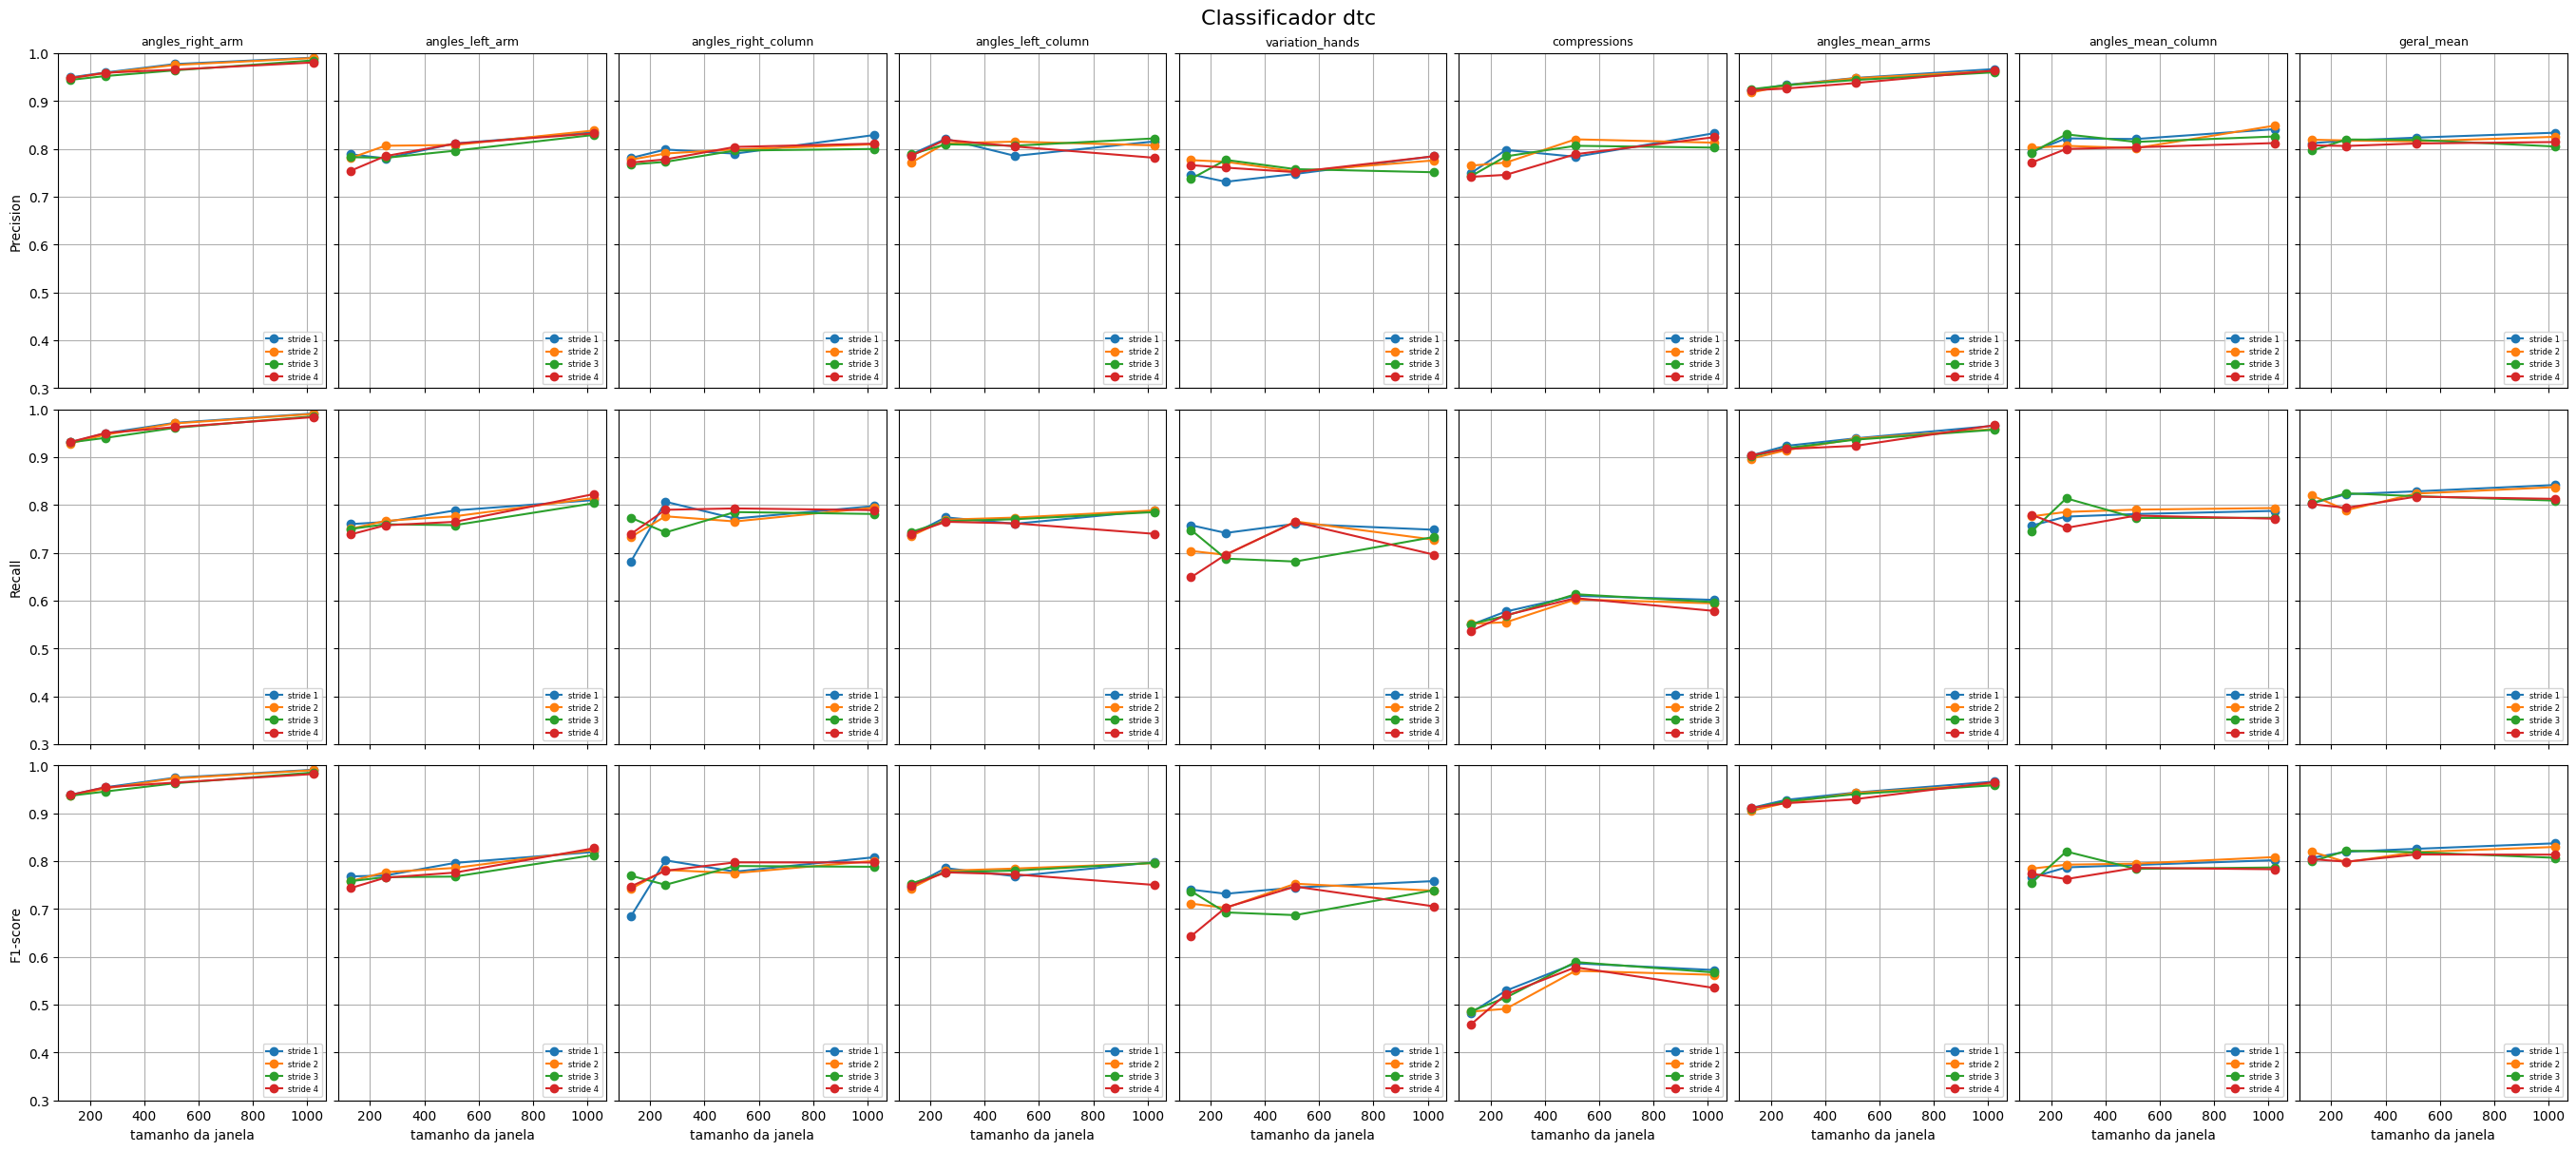

In [ ]:
plot_reports("dtc","/content/drive/MyDrive/reports")

In [ ]:
def plot_comp_models(clfs, base_dir, janela):
  FEATURES = [
      'angles_right_arm', 'angles_left_arm', 'angles_right_column',
      'angles_left_column', 'variation_hands', 'compressions',
      'angles_mean_arms', 'angles_mean_column', 'geral_mean']
  strides = [1, 2, 3, 4]
  metricas = ['precision', 'recall', 'f1-score']
  results_data = {}  #results_data[feature][clf][métrica]
  for f in FEATURES:
    data_dir = os.path.join(base_dir, f) #caminho
    feat_res = {} # dicionario para esta feature
    for c in clfs:
      feat_res[c] = {} # para cada classificador cria um subdicionario
      for m in metricas:
        feat_res[c][m] = [] # lista vazia cada metrica
      for s in strides:
        fn = f"{c}_{janela}_{s}_report.csv" # arquivo com os dados
        path = os.path.join(data_dir, fn)
        df = pd.read_csv(path, index_col=0) # primeira coluna
        for m in metricas:
          feat_res[c][m].append(df.loc[m, 'macro avg']) #pega a macro avg
    results_data[f] = feat_res # valores da feature

  n_rows, n_cols = 3, 9
  fig, axs = plt.subplots(n_rows, n_cols,figsize=(n_cols * 3, n_rows * 4),sharex='col', sharey='row',constrained_layout=True)
  fig.suptitle(f"Comparacao de Classificadores J={janela}", fontsize=16)

  # for para preencher cada célula do grid
  for col, f in enumerate(FEATURES):
    for row, m in enumerate(metricas):
      ax = axs[row][col]
      for clf in classifiers:
        ax.plot(strides,results_data[f][clf][m],marker='o',label=clf)
      ax.set_ylim(0.3, 1.0)
      if row == 0:
        ax.set_title(f, fontsize=9)
      if row == n_rows - 1:
        ax.set_xlabel("Stride")
      if col == 0:
        ax.set_ylabel(m)
      ax.grid(True)
      ax.legend(fontsize=6, loc='lower right')

  out_path = os.path.join(base_dir, f"j{janela}_comp.png")
  fig.savefig(out_path)
  print(f"Gráfico salvo em: {out_path}")

  plt.show()

Gráfico salvo em: /content/drive/MyDrive/reports/j1024_comp.png


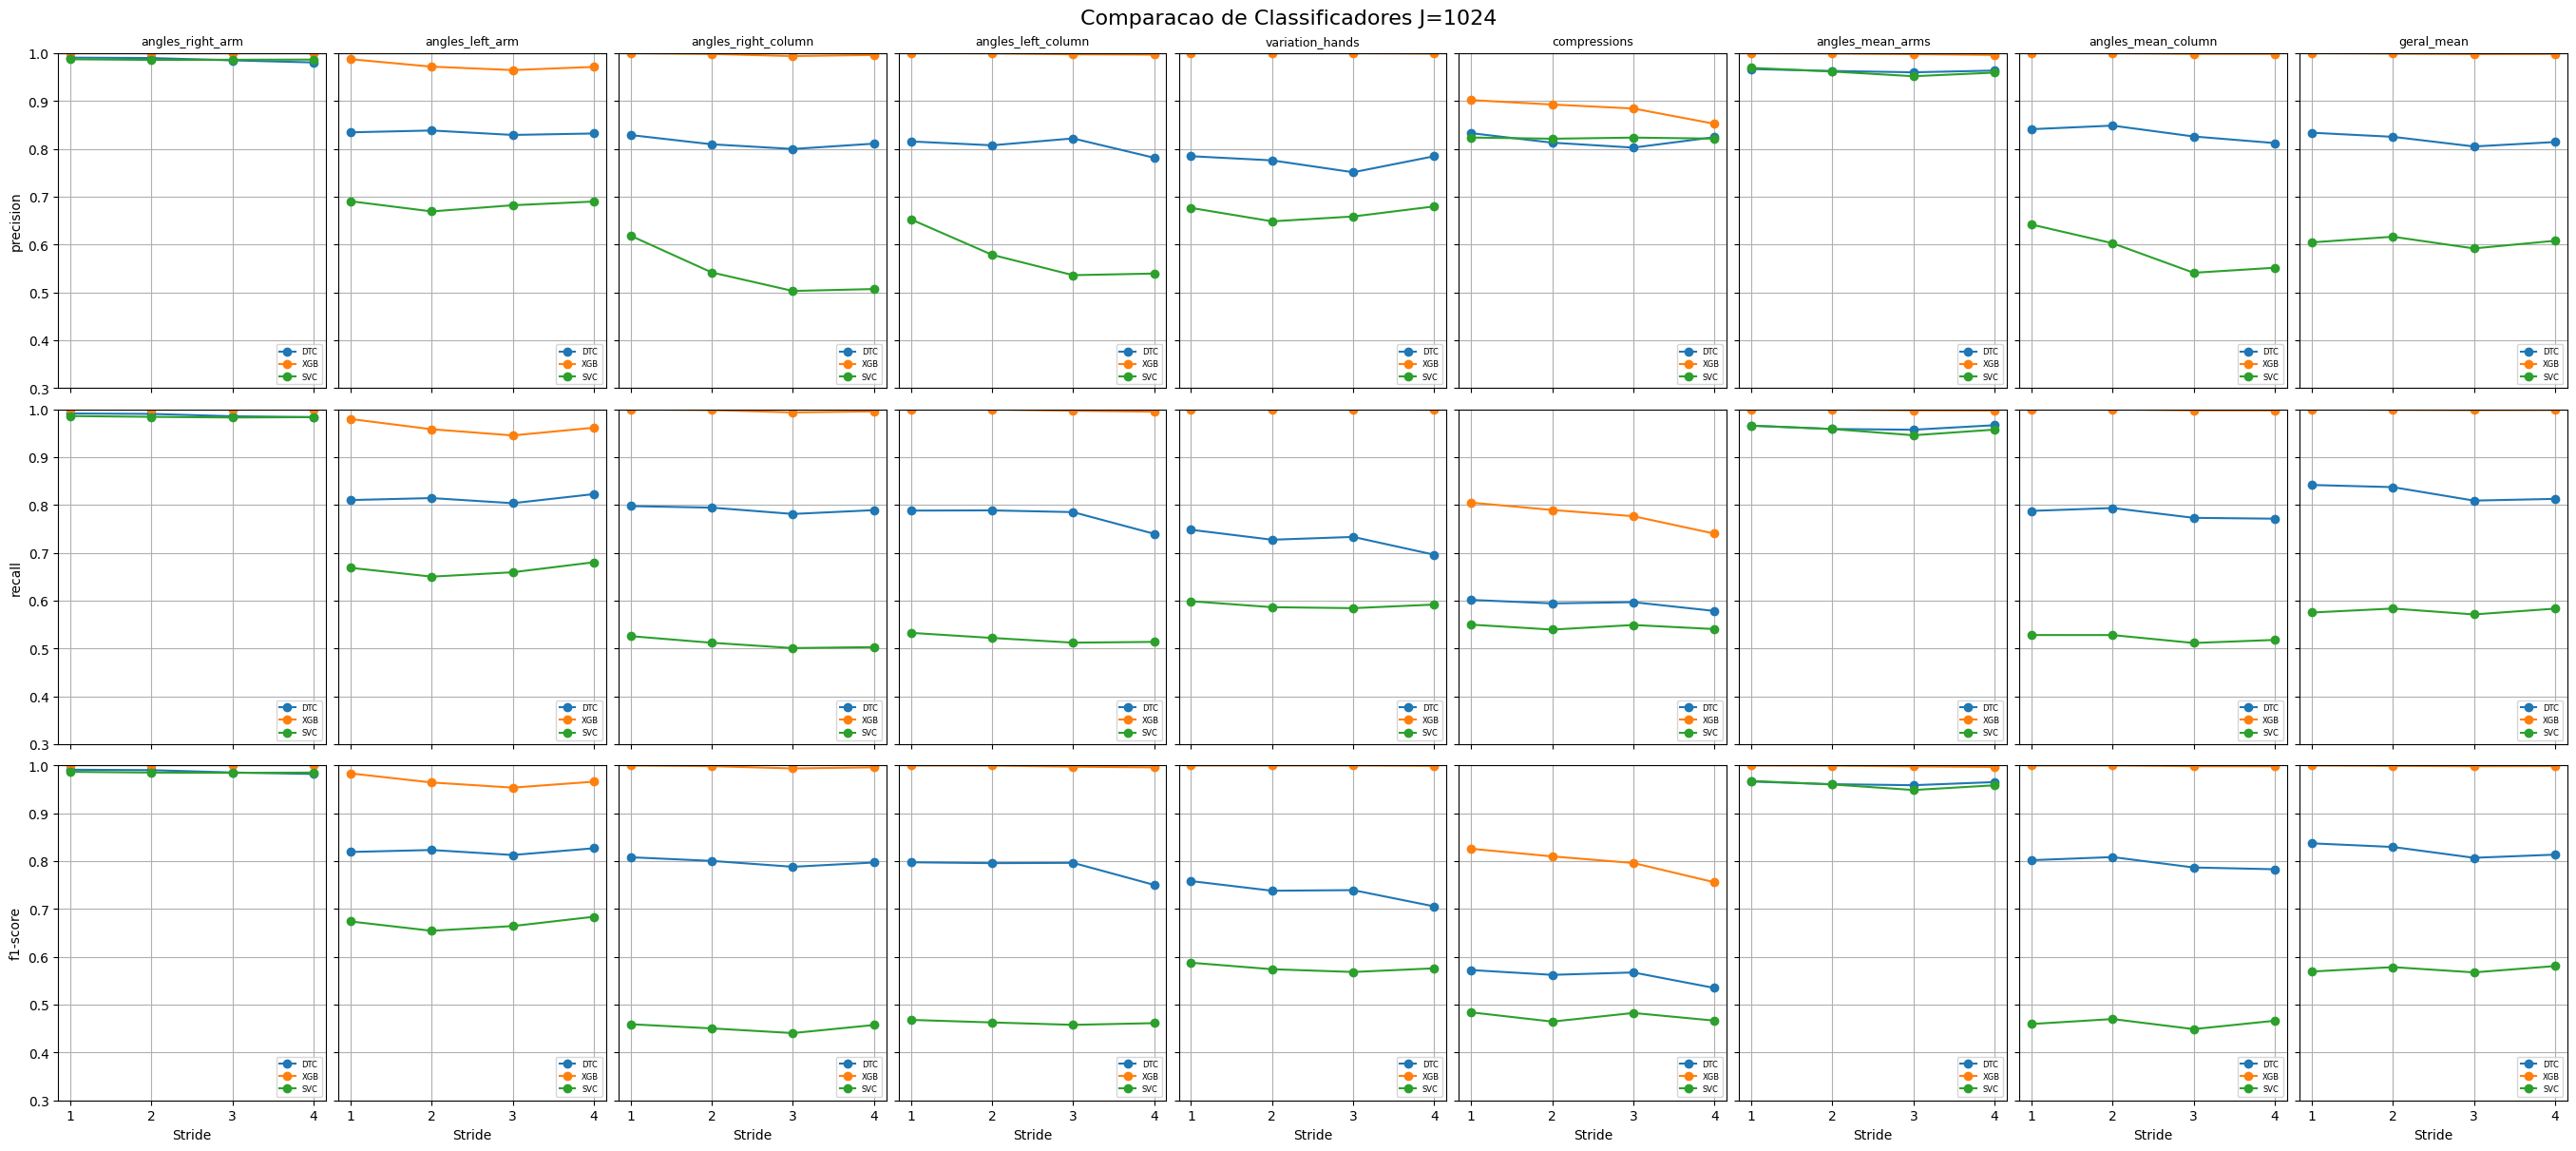

In [ ]:
classificadores = ['dtc', 'xgb', 'svc']
plot_comp_models(classificadores, "/content/drive/MyDrive/reports", 2**10)

# Clusterização Não-supervisionada

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score,adjusted_rand_score

In [ ]:
def k_optimize(X):
  scores = {}
  for k in range(2,10):
    km = (KMeans(n_clusters=k, random_state=42))
    labels = km.fit_predict(X)
    scores[k] = silhouette_score(X, labels)
  best_k = max(scores, key=scores.get)
  print("Melhor k:", best_k)

  return best_k

In [ ]:
def train_kmeans(X, y):
  #escala
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  #ajusta o modelo
  k = k_optimize(X_scaled)
  print(f"Número de clusters: {k}")
  km = KMeans(n_clusters=k, random_state=42, n_init='auto')
  labels = km.fit_predict(X_scaled)
  #PCA para visualizar
  pca = PCA(n_components=2, random_state=42)
  X2 = pca.fit_transform(X_scaled)
  plt.figure(figsize=(6,6))
  scatter = plt.scatter(X2[:,0], X2[:,1], c=labels, s=5, cmap='tab10')
  plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1,1))
  plt.title(f'KMeans com k={k}')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()

  labels = km.fit_predict(X_scaled)
  print("Silhouette:", silhouette_score(X_scaled, labels))
  print("Calinski–Harabasz:", calinski_harabasz_score(X_scaled, labels))
  print("Davies–Bouldin:", davies_bouldin_score(X_scaled, labels))
  print("Adjusted Rand Index:", adjusted_rand_score(y, labels))
  return km

Melhor k: 2
Número de clusters: 2


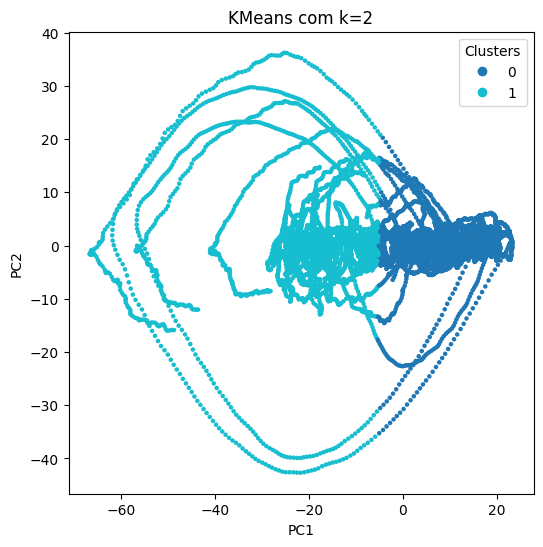

Silhouette: 0.5475240832361701
Calinski–Harabasz: 43572.960630843074
Davies–Bouldin: 0.7387792435903358
Adjusted Rand Index: 0.6657857247667814


In [ ]:
clf = train_kmeans(X,y)

analisar dados por modelo, dado
modelo x dado
fixar xgoost variar janela
fixar janela variar xgboost
